In [57]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import matplotlib.pyplot as plt
import pathlib

In [58]:
# project specific path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/oa/'

In [59]:
# from AC Q2 run of merged saliva stool
df_map = pd.read_csv(path + 'inputs/Qiime2_0/qiime_mapping_file.tsv', sep='\t', index_col=0)
q2_row = df_map.loc['#q2:types',:]
df_map = df_map.drop('#q2:types')

# change index so it matches metadata file
df_map.index = df_map.index.map(lambda x: x.split('.guma')[0])

# drop MOC and elution buffer
df_map = df_map.drop(['MOC.320','elutionbuffer.plate313'])

# grab metadata
df_meta = pd.read_csv(path + 'inputs/Metadata_OA.csv')

# rename 'Run_ID_Saliva' to be correct
df_meta['Timepoints'] = df_meta['Timepoints'].apply(lambda x: 'pre' if x == '0' else 'post')
df_meta['Patient_ID'] = df_meta['Patient_ID'].apply(lambda x: x[:-3])  
df_meta['Study_ID'] = df_meta['Study_ID'].apply(lambda x: x.split('_')[0][-3:]) 

# create per sample type mapping files
type_to_ST = {'saliva':'Saliva','stool':'fecal'}
type_to_df_map = {}

# split into specimen type
for t in type_to_ST:
    # subset on specimen type
    df_map_type = df_map[df_map['SpecimenType'] == type_to_ST[t]]

    # as to not overwrite df meta
    df_meta_type = df_meta.copy()

    # create new sample ID for specimen type and set as index
    df_meta_type['#SampleID'] = df_meta['Patient_ID'] + '-' + df_meta['Study_ID'] + '.' + df_meta['Timepoints'] + '.' + t
    df_meta_type = df_meta_type.set_index('#SampleID')

    # create full mapping file
    df_map_type = pd.concat([df_map_type, df_meta_type],axis=1)

    # use only sequenced samples
    df_map_type = df_map_type.dropna(how='any',subset='BarcodeSequence')

    # drop all na columns
    df_map_type = df_map_type.dropna(how='all',axis=1)

    # drop VAD OA 015 because misdx with PsA not OA
    if t == 'saliva':
        df_map_type = df_map_type.drop(['VAOAD-015.pre.saliva','VAOAD-015.post.saliva'])
    if t == 'stool':
        df_map_type = df_map_type.drop(['VAOAD-015.pre.stool','VAOAD-015.post.stool'])

    # populate dict of mapping files
    type_to_df_map[t] = df_map_type

    # export for q2
    df_q2_type = pd.concat([q2_row.to_frame().T, df_map_type])
    df_q2_type.index.name = '#SampleID'
    df_q2_type.iloc[0,:] = 'categorical'
    df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + t + '.tsv', sep='\t')
    df_q2_type = df_q2_type[df_q2_type['Adherece_antiinflam'].isin(['Moderate adherence', 'High adherence','categorical'])]
    df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + t + '_adh.tsv', sep='\t')

type_to_df_map['stool'].head()

,BarcodeSequence,LinkerPrimerSequence,Separate,Timepoint,Together,ContactEmail,ContactName,PrimaryInvestigator,Cohort,RawDataNotes,...,broccoli,Garbanzo_beans,pork,beef,burger,Total_omega3,Adherence_omega3,Total_omega6,Adherence_omega6,Total_o3_o6
#SampleID,,,,,,,,,,,,,,,,,,,,,
OAD-001.pre.stool,TTCAGTTCGTTA,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-001.pre.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-001.pre.stool.guma.plate313,...,0.0,0.0,0.0,0.0,0.0,NaN,Low adherence,NaN,Low adherence,0.0
OAD-001.post.stool,CGGCCAGAAGCA,CCGGACTACHVGGGTWTCTAAT,All,post,OAD-001.post.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-001.post.stool.guma.plate313,...,4.0,0.0,0.0,0.0,0.0,48.0,Low adherence,72.0,Low adherence,131.0
OAD-003.pre.stool,GACGTTAAGAAT,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-003.pre.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-003.pre.stool.guma.plate313,...,0.0,0.0,0.0,14.0,0.0,16.8,Low adherence,53.2,High adherence,75.0
OAD-003.post.stool,TCGCTACAGATG,CCGGACTACHVGGGTWTCTAAT,All,post,OAD-003.post.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-003.post.stool.guma.plate313,...,4.0,0.0,0.0,0.0,0.0,48.0,Low adherence,108.0,High adherence,171.0
OAD-004.pre.stool,ATGGGACCTTCA,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-004.pre.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-004.pre.stool.guma.plate313,...,2.8,0.0,0.0,0.0,0.0,2.8,Low adherence,28.0,Low adherence,35.8


In [61]:
###
# Hypothesis 1: There will be a measurable difference in WOMAC pain response scores and 
# other outcomes from baseline to after the dietary intervention.
###

# outcome variables
outcomes = ['VAS_Pt', 'VAS_overall', 'WOMAC_pain', 'WOMAC_stiffness', 'WOMAC_activity', 'WOMAC_total', 'Pain_DETECT', 
            'CES_D', 'Helplesness', 'Magnification', 'Rumination', 'PCS_EN', 'Sleep_distrubance', 'PASE_walk', 'PASE_light', 
            #'PASE_gardening', # Where did this go? gardening_improve is binary
            'BMI']


# hypothesis 1
# create a new df_meta
df_meta = pd.read_csv(path + 'inputs/Metadata_OA.csv')

# rename 'Run_ID_Saliva' to be correct
df_meta['Timepoints'] = df_meta['Timepoints'].apply(lambda x: 'pre' if x == '0' else 'post')
df_meta['Patient_ID'] = df_meta['Patient_ID'].apply(lambda x: x[:-3])  
df_meta['Study_ID'] = df_meta['Study_ID'].apply(lambda x: x.split('_')[0][-3:]) 
df_meta['#SampleID'] = df_meta['Patient_ID'] + '-' + df_meta['Study_ID'] + '.' + df_meta['Timepoints'] + '.stool'
df_meta = df_meta.set_index('#SampleID')

# convert % to floats for calculations down the road
bin = []
cont = []
for w in outcomes:
    df_w = df_meta[w]
    if df_w.nunique() > 2: # do spearman
        df_meta[w] = df_meta[w].astype(str).str.replace('%','').astype(float).values
        cont.append(w)
    else:
        bin.append(w)

print(bin)
print(cont)

# split into all and mod high only
for a in ['all','modhigh']:
    print(a)
    if a == 'all':
        job = 'jobs03'
    if a == 'modhigh':
        job = 'jobs02'
        df_meta = df_meta[df_meta['Adherece_antiinflam'].isin(['Moderate adherence', 'High adherence'])]
    print(len(df_meta))
    
    df_results = pd.DataFrame(columns=['var','effect','pval','stat'])
    # do post treatment vals of binary vars differ from pre treatment 'unpaired'
    for b in bin:
        ct_table_ind=pd.crosstab(df_meta["Timepoints"],df_meta[b])
        chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)
        row=pd.DataFrame.from_dict({'var': [b],'effect':[chi2_stat],'pval':[p],'stat':['chi2']})
        df_results = pd.concat([df_results, row])
    
    # fishers exact
    for b in bin:
        ct_table_ind=pd.crosstab(df_meta["Timepoints"],df_meta[b])
        fisher, p = scipy.stats.fisher_exact(ct_table_ind)
        row=pd.DataFrame.from_dict({'var': [b],'effect':[t],'pval':[p],'stat':['fisher']})
        df_results = pd.concat([df_results, row])
        
    # do post treatment vals of continuous vars differ from pre treatment unpaired
    df_pre = df_meta[df_meta['Timepoints'] == 'pre']
    df_post = df_meta[df_meta['Timepoints'] == 'post']
    for c in cont:
        try:
            W,p = scipy.stats.mannwhitneyu(x=df_pre[c].values,y=df_post[c].values, nan_policy='omit')
        except:
            W,p = 0, 1
        row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['mwu']})
        if p < 0.05:
            ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
            sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
        
            # ax.axes.set_title("Title",fontsize=48)
            ax.set_ylabel(c,fontsize=16)
            ax.set_xlabel('Timepoints',fontsize=16)                
            ax.tick_params(labelsize=16)
            sns.despine()
            plt.tight_layout()
            plt.savefig(path + 'outputs/' + job + '/mwu_' + c  + '.pdf')
            plt.close()            
        row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['MWU']})
        df_results = pd.concat([df_results, row])
        
    df_pre = df_meta[df_meta['Timepoints'] == 'pre']
    df_post = df_meta[df_meta['Timepoints'] == 'post']
    for c in cont:
        t,p = scipy.stats.ttest_ind(a=df_pre[c].values,b=df_post[c].values, nan_policy='omit')
        row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['ttest']})
        if p < 0.05:
            ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
            sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
        
            # ax.axes.set_title("Title",fontsize=48)
            ax.set_ylabel(c,fontsize=16)
            ax.set_xlabel('Timepoints',fontsize=16)                
            ax.tick_params(labelsize=16)
            sns.despine()
            plt.tight_layout()
            plt.savefig(path + 'outputs/' + job + '/tt_' + c  + '.pdf')
            plt.close()            
        row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['ttest']})
        df_results = pd.concat([df_results, row])

    # unpaired and then paired
    df_pre = df_meta[df_meta['Timepoints'] == 'pre']
    df_post = df_meta[df_meta['Timepoints'] == 'post']
    for c in cont:
        W,p = scipy.stats.wilcoxon(x=df_pre[c].values,y=df_post[c].values, nan_policy='omit')
        row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['WSR']})
        if p < 0.05:
            ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
            sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
        
            # ax.axes.set_title("Title",fontsize=48)
            ax.set_ylabel(c,fontsize=16)
            ax.set_xlabel('Timepoints',fontsize=16)                
            ax.tick_params(labelsize=16)
            sns.despine()
            plt.tight_layout()
            plt.savefig(path + 'outputs/' + job + '/wsr_' + c  + '.pdf')
            plt.close()            
        row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['WSR']})
        df_results = pd.concat([df_results, row])

    df_pre = df_meta[df_meta['Timepoints'] == 'pre']
    df_post = df_meta[df_meta['Timepoints'] == 'post']
    for c in cont:
        t,p = scipy.stats.ttest_rel(a=df_pre[c].values,b=df_post[c].values, nan_policy='omit')
        row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['pairedt']})
        if p < 0.05:
            ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
            sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
        
            # ax.axes.set_title("Title",fontsize=48)
            ax.set_ylabel(c,fontsize=16)
            ax.set_xlabel('Timepoints',fontsize=16)                
            ax.tick_params(labelsize=16)
            sns.despine()
            plt.tight_layout()
            plt.savefig(path + 'outputs/' + job + '/pairedt_' + c  + '.pdf')
            plt.close()          
        row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['pairedt']})
        df_results = pd.concat([df_results, row])

    df_results.to_csv(path + 'outputs/' + job + '/outcome_testing.tsv', sep='\t')
df_results.head()
    

[]
['VAS_Pt', 'VAS_overall', 'WOMAC_pain', 'WOMAC_stiffness', 'WOMAC_activity', 'WOMAC_total', 'Pain_DETECT', 'CES_D', 'Helplesness', 'Magnification', 'Rumination', 'PCS_EN', 'Sleep_distrubance', 'PASE_walk', 'PASE_light', 'BMI']
all
42
modhigh
32


,var,effect,pval,stat
0,VAS_Pt,198.5,0.008316,MWU
0,VAS_overall,168.5,0.131314,MWU
0,WOMAC_pain,170.0,0.017900,MWU
0,WOMAC_stiffness,172.5,0.013052,MWU
0,WOMAC_activity,164.5,0.032592,MWU


In [62]:
df_meta = pd.read_csv(path + 'inputs/Metadata_OA.csv')
# df = df_meta[df_meta['Adherece_antiinflam'].isnull()]
# df = df_meta[df_meta['Adherece_antiinflam'] != 'Low adherence']
df = df_meta[df_meta['Adherece_antiinflam'] == 'Low adherence']
# df['Patient_ID'].unique()
# df_meta
df

,Patient_ID,Timepoints,Study_ID,Run_ID_Stool,Run_ID_Saliva,Visit,Sex,Age,Height,Weight,...,broccoli,Garbanzo_beans,pork,beef,burger,Total_omega3,Adherence_omega3,Total_omega6,Adherence_omega6,Total_o3_o6
32,VAOAD009,0,VAOAD009_0,VAOAD-009.pre.stool,VAOAD-009.pre.saliva,d-15/d0,M,71,189.0,130.500,...,0.0,0.0,0.0,0.0,0.0,NaN,Moderate adherence,NaN,Low adherence,0.0
33,VAOAD009,1m,VAOAD009_1m,VAOAD-009.post.stool,VAOAD-009.post.saliva,4W,M,71,189.0,130.000,...,0.0,0.0,0.0,0.0,0.0,79.8,Moderate adherence,89.6,Low adherence,179.4
40,VAOAD014,0,VAOAD014_0,VAOAD-014.pre.stool,VAOAD-014.pre.saliva,d-15/d0,M,76,169.0,75.055,...,0.0,0.0,39.2,0.0,0.0,14.0,Low adherence,47.6,Low adherence,66.6
41,VAOAD014,1m,VAOAD014_1m,NaN,NaN,4W,M,76,169.0,73.500,...,4.0,0.0,14.0,2.0,0.0,22.0,Low adherence,68.0,Low adherence,105.0


In [9]:
###
# Hypothesis 2: There will be an association between oral and gut microbiome and pain outcomes
###
# construct alpha, beta and paired alpha dataframes
g_to_dfd = {}
g_test = ['stool','saliva_adh', 'stool_adh', 'saliva']

for g in g_test:
    # maps diversity type to dataframe
    g_to_dfd[g] = {}
    
    # get alpha diversities
    df_alpha = pd.read_csv(path + 'outputs/Qiime2_' + g + '/metadata.tsv', sep='\t', index_col=0)
    df_alpha = df_alpha.drop('#q2:types')
    df_alpha['SubjectID'] = df_alpha['Patient_ID'] + df_alpha['Study_ID']
    df_alpha = df_alpha[['SubjectID', 'Timepoints', 'shannon_entropy']]
    g_to_dfd[g]['alpha'] = df_alpha

    # get paired alpha div, first drop unpaired samples
    s_remove = []
    for s in list(df_alpha['SubjectID'].values):
        if len(df_alpha[df_alpha['SubjectID'] == s]) != 2:
            s_remove.append(s)
    df_alpha = df_alpha.loc[~df_alpha['SubjectID'].isin(s_remove),:] # careful not to use ([s_remove])
    
    # set vars
    alpha_metric = 'shannon_entropy'
    group_var = 'Timepoints'
    pair_var = 'SubjectID'
    groups = ['pre','post']
    
    # get paired per indiv pair
    pair_to_diff = {}
    for p in list(df_alpha[pair_var].values):
        df = df_alpha[df_alpha[pair_var] == p]
        alpha_0 = float(df[df[group_var] == groups[0]][alpha_metric].values)
        alpha_1 = float(df[df[group_var] == groups[1]][alpha_metric].values)
        pair_to_diff[p] = alpha_0 - alpha_1
    
    df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[alpha_metric + '_diff'])
    g_to_dfd[g]['paired_alpha'] = df_paired_alpha

    # get beta div
    df_beta = pd.read_csv(path + 'outputs/Qiime2_' + g + '/core_metrics_results/distance-matrix.tsv',
                              sep='\t', index_col=0)
        
    # grab twin to pair dict
    pair_to_ids = {}
    for p in list(df_alpha[pair_var].values):
        df = df_alpha[df_alpha[pair_var] == p]
        id_0 = str(df[df[group_var] == groups[0]].index.values[0])
        id_1 = str(df[df[group_var] == groups[1]].index.values[0])
        pair_to_ids[p] = (id_0, id_1)
    
    # get distances for each twin pair per beta div matrix    
    pair_to_dist = {}
    for p in list(df_alpha[pair_var].values):
        id_0, id_1 = pair_to_ids[p]
        pair_to_dist[p] = df_beta.loc[id_0, id_1]
    
    df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Unweighted_Unifrac'])
    g_to_dfd[g]['paired_beta'] = df_paired_beta


# compute paired differences in pain
        # compute the paired differences


g_to_dfd['stool']['paired_beta'].head()

,Unweighted_Unifrac
OAD001,0.6598
OAD003,0.2810
OAD004,0.4327
OAD005,0.3237
OAD006,0.1000


In [108]:
# here we are using all samples at all time points to see if microbiome associates with pain level
# we start with alpha diversity only

# boxplot of high versus low adherence, Y axis is delta of alpha pre-post
# boxplot of high (H = high and moderate) versus low adherence, Y axis is distance pre-post
def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(scipy.stats.chi2_contingency(ctsum.fillna(0)))

# quartiles of response. Pick top vs bottom quartile, do chi-sq with H vs L adherence
# boxplots of top responders vs non-responders in distance pre-post
# boxplots of top vs non-responders in delta of alpha pre-post
d_to_metric = {
    'alpha': 'shannon_entropy',
}
group_var = 'Adherece_antiinflam'

dfd_to_merge = {}
g
for g in g_test:
    dfd_to_merge[g] = {}

gs = []
ds = []
os = []
stats = []
ts = []
ps = []

arr = [gs,ds,os,stats,ts,ps]

def append_results(arr, val):
    for a,v in zip(arr,val):
        a.append(v)
    return arr

# for each sample type, grab relevant mapping file
# g_test = saliva, saliva_adh, stool, etc.
for g in g_test:
    for d in d_to_metric:
        # grab relevant diversity df
        df_div = g_to_dfd[g][d]

        if d == 'alpha':
            # df_div = df_div[df_div['Timepoints'] == 'pre']
            # df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            # df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            df_div['shannon_entropy'] = df_div['shannon_entropy'].astype(float)

        # merge with df of metadata var        
        # grab relevant sample IDs
        idx = 'Run_ID_' + g.capitalize()
        df_meta_sub = df_meta.dropna(subset=idx)
        df_meta_sub = df_meta_sub.set_index(idx)
        df_merge = pd.concat([df_meta_sub,df_div],axis=1)

        # test association of div with outcomes
        for o in outcomes:            
            if o in 'PASE_light' or o in 'PASE_walk' or o in 'Magnification': # only 2
                df_merge[o + '_quartiles'] = np.where(df_merge[o]==0, 'bottom', 'top')
            #elif o in 'Magnification': # only 3 
            #    df_merge[o + '_quartiles'] = pd.qcut(df_merge[o].values, 3, labels = ['top','mid','bottom'])#, duplicates='drop')  
            else:
                df_merge[o + '_quartiles'] = pd.qcut(df_merge[o].values, 4, labels = ['top','midtop','midbot','bottom'])#, duplicates='drop')  
                
            # test association of adherence with pain outcomes
            div_metric = d_to_metric[d]
            x,p,dof,ef = chisq_of_df_cols(df_merge, group_var, o + '_quartiles')
            arr = append_results(arr, ['metadata',group_var,o,'chisq',x,p])
            
            ax = sns.boxplot(data=df_merge, x=o + '_quartiles', y=div_metric)
            sns.swarmplot(data=df_merge, x=o + '_quartiles', y=div_metric, palette='dark:grey')
            sns.despine()
        
            plt.tight_layout()
            plt.savefig(path + 'outputs/Qiime2_' + g + '/quartiles_nondiff_' + o + '_' + d + '.pdf')
            plt.close()          
        
            u, p = scipy.stats.mannwhitneyu(df_merge[df_merge[o + '_quartiles'] == 'top'][div_metric].values, 
                                            df_merge[df_merge[o + '_quartiles'] == 'bottom'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'mwu',t,p])

            t, p = scipy.stats.ttest_ind(df_merge[df_merge[o + '_quartiles'] == 'top'][div_metric].values, 
                                            df_merge[df_merge[o + '_quartiles'] == 'bottom'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'tt',t,p])

        # save results
        dfd_to_merge[g][d] = df_merge

        # export to Q2
        # df_q2_type = df_merge.set_index(['Together'])
        df_q2_type = df_merge.copy()
        q2_row = pd.Series(data=['categorical' for i in range(len(df_merge.columns))], 
                           index=list(df_merge.columns.values), dtype=str, name='#q2:types')
        df_q2_type = pd.concat([q2_row.to_frame().T, df_q2_type])
        df_q2_type.index.name = '#SampleID'
        df_q2_type.index = df_q2_type.index.map(lambda x: x.split('.guma')[0])
        df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + d + '_' + g + 'aggregate_outcomes.tsv', sep='\t')

df_results = pd.DataFrame.from_dict({
    'group': gs,
    'div': ds,
    'outcome': os,
    'statistic': stats,
    'test_stat': ts,
    'pval': ps
})
df_results.to_csv(path + 'outputs/df_results_aggregate.tsv', sep='\t')

# df_results.head()
df_results[df_results['pval'] < 0.05]

,group,div,outcome,statistic,test_stat,pval
8,stool,alpha,WOMAC_pain,tt,2.182980,0.046561
12,metadata,Adherece_antiinflam,WOMAC_activity,chisq,17.206778,0.008553
15,metadata,Adherece_antiinflam,WOMAC_total,chisq,17.635958,0.007209
21,metadata,Adherece_antiinflam,CES_D,chisq,12.705628,0.047956
24,metadata,Adherece_antiinflam,Helplesness,chisq,13.621090,0.034167
40,stool,alpha,PASE_walk,mwu,-0.324777,0.041176
41,stool,alpha,PASE_walk,tt,2.424221,0.020809
42,metadata,Adherece_antiinflam,PASE_light,chisq,10.145400,0.006265
45,metadata,Adherece_antiinflam,BMI,chisq,15.544444,0.016420
60,metadata,Adherece_antiinflam,WOMAC_activity,chisq,17.206778,0.008553


In [115]:
# boxplot of high versus low adherence, Y axis is delta of alpha pre-post
# boxplot of high (H = high and moderate) versus low adherence, Y axis is distance pre-post
def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(scipy.stats.chi2_contingency(ctsum.fillna(0)))

# quartiles of response. Pick top vs bottom quartile, do chi-sq with H vs L adherence
# boxplots of top responders vs non-responders in distance pre-post
# boxplots of top vs non-responders in delta of alpha pre-post
d_to_metric = {
    'alpha': 'shannon_entropy',
    'paired_alpha': 'shannon_entropy_diff',
    'paired_beta': 'Unweighted_Unifrac'
}
group_var = 'Adherece_antiinflam'

dfd_to_merge = {}
g_test = ['stool','stool_adh','saliva','saliva_adh']
for g in g_test:
    dfd_to_merge[g] = {}

gs = []
ds = []
os = []
stats = []
ts = []
ps = []

arr = [gs,ds,os,stats,ts,ps]

def append_results(arr, val):
    for a,v in zip(arr,val):
        a.append(v)
    return arr

# for each sample type, grab relevant mapping file
# g_test = saliva, saliva_adh, stool, etc.
for g in g_test:
    # drop duplicates so you have sample mapping to adh
    df_map_sub = type_to_df_map[g.split('_')[0]]
    df_map_sub.index = df_map_sub.index.map(lambda x: x.split('.')[0].replace('-',''))
    df_map_sub = df_map_sub.dropna(how='any',subset=group_var,axis=0)           
    
    # figure out which samples to keep
    # i.e. samples that have a pre and post time point
    keep = []
    for i in list(df_map_sub.index.values):
        if len(df_map_sub.loc[i,:]) == 2:
            keep.append(i)

    # get unique entires in sorted order
    # at this point we are only concerned with differences in values, 
    # as we've dropped samples with only one endpoint val
    save = []
    [save.append(x) for x in keep if x not in save]
    df_map_sub = df_map_sub.loc[save,:]

    # this double populates as OAD001 is an index twice, so the diff fills to both the pre and post col
    for o in outcomes:
        df_map_sub[o + '_diff'] = df_map_sub[df_map_sub['Timepoint'] == 'post'][o] - df_map_sub[df_map_sub['Timepoint'] == 'pre'][o] 

    # here we keep only the pre, but everything is identical b/w pre and post
    df_dropdup = df_map_sub[~df_map_sub.index.duplicated(keep='first')]

    for d in d_to_metric:
        # grab relevant diversity df
        df_div = g_to_dfd[g][d]

        if d == 'alpha':
            df_div = df_div[df_div['Timepoints'] == 'pre']
            df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            df_div = df_div.astype(float)

        # merge with df of metadata var        
        df_merge = pd.concat([df_dropdup,df_div],axis=1)

        # drop na in barcodes if samples not sequenced both pre and post
        df_merge = df_merge.dropna(how='any',subset='BarcodeSequence')

        # build expandable arrays
        values = list(df_merge[group_var].unique())
        arr_list = [list(df_merge.groupby([group_var]).get_group(values[i])[d_to_metric[d]].values) for i in range(len(values))]
    
        # test difference of paired differences between two adherence groups (mod vs high only)
        if len(g.split('_')) == 2:
            s, p = scipy.stats.mannwhitneyu(arr_list[0], arr_list[1], nan_policy='omit')
            arr = append_results(arr, [g,d,'adh','mwh',s,p])

            s, p = scipy.stats.ttest_ind(arr_list[0], arr_list[1], nan_policy='omit')
            arr = append_results(arr, [g,d,'adh','tt',s,p])

        if len(g.split('_')) == 1: # tests across all 3 groups
            s, p = scipy.stats.kruskal(*arr_list, nan_policy='omit')
            arr = append_results(arr, [g,d,'adh','kw',s,p])

            #f, p = scipy.stats.f_oneway(*arr_list, nan_policy='omit')
            #print(f, p)

        # separate plot
        div_metric = d_to_metric[d]
        df_merge[div_metric] = df_merge[div_metric].map(lambda x: float(x))
        ax = sns.boxplot(data=df_merge, x=group_var, y=div_metric)
        sns.swarmplot(data=df_merge, x=group_var, y=div_metric, palette='dark:grey')
        sns.despine()
        
        plt.tight_layout()
        plt.savefig(path + 'outputs/Qiime2_' + g + '/' + d + '.pdf')
        plt.close()          

        # test association of div with outcomes
        for o in outcomes:            
            if o in 'PASE_light' or o in 'PASE_walk': # only 2
                df_merge[o + '_quartiles'] = np.where(df_merge[o + '_diff']==0, 'bottom', 'top')
            #elif o in 'PASE_walk': # only 3 
            #    df_merge[o + '_quartiles'] = pd.qcut(df_merge[o + '_diff'].values, 3, labels = ['top','mid','bottom'])#, duplicates='drop')  
            else:
                df_merge[o + '_quartiles'] = pd.qcut(df_merge[o + '_diff'].values, 4, labels = ['top','midtop','midbot','bottom'])#, duplicates='drop')  
                
            # test association of adherence with pain outcomes
            x,p,dof,ef = chisq_of_df_cols(df_merge, group_var, o + '_quartiles')
            arr = append_results(arr, ['metadata','chisq',o,group_var,x,p])
            
            ax = sns.boxplot(data=df_merge, x=o + '_quartiles', y=div_metric)
            sns.swarmplot(data=df_merge, x=o + '_quartiles', y=div_metric, palette='dark:grey')
            sns.despine()
        
            plt.tight_layout()
            plt.savefig(path + 'outputs/Qiime2_' + g + '/quartiles_' + o + '_' + d + '.pdf')
            plt.close()          
        
            u, p = scipy.stats.mannwhitneyu(df_merge[df_merge[o + '_quartiles'] == 'top'][div_metric].values, 
                                            df_merge[df_merge[o + '_quartiles'] == 'bottom'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'mwu',t,p])

            t, p = scipy.stats.ttest_ind(df_merge[df_merge[o + '_quartiles'] == 'top'][div_metric].values, 
                                            df_merge[df_merge[o + '_quartiles'] == 'bottom'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'tt',t,p])

        # save results
        dfd_to_merge[g][d] = df_merge

        # export to Q2
        df_q2_type = df_merge.set_index(['Together'])
        q2_row = pd.Series(data=['categorical' for i in range(len(df_merge.columns))], 
                           index=list(df_merge.columns.values), dtype=str, name='#q2:types')
        df_q2_type = pd.concat([q2_row.to_frame().T, df_q2_type])
        df_q2_type.index.name = '#SampleID'
        df_q2_type.index = df_q2_type.index.map(lambda x: x.split('.guma')[0])
        df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + d + '_' + g + '_outcomes.tsv', sep='\t')

df_results = pd.DataFrame.from_dict({
    'group': gs,
    'div': ds,
    'outcome': os,
    'statistic': stats,
    'test_stat': ts,
    'pval': ps
})
df_results.to_csv(path + 'outputs/df_results_diff.tsv', sep='\t')

# df_results.head()
# the div==alpha results test whether pre-alpha div state associates with pain outcome changes (differences) quartiles
# the div==paired_alpha and paired_beta test whether the alpha and betas change in a similar way with the pain outcome
df_results[df_results['pval'] < 0.05]

,group,div,outcome,statistic,test_stat,pval
64,stool,paired_alpha,WOMAC_activity,tt,-3.013993,0.023579
67,stool,paired_alpha,WOMAC_total,tt,-3.793806,0.012709
201,stool_adh,paired_alpha,VAS_Pt,tt,-3.058171,0.028161
204,stool_adh,paired_alpha,VAS_overall,tt,-3.164672,0.024964
207,stool_adh,paired_alpha,WOMAC_pain,tt,-3.960201,0.016675
213,stool_adh,paired_alpha,WOMAC_activity,tt,-3.052571,0.022438
216,stool_adh,paired_alpha,WOMAC_total,tt,-3.761469,0.013138
315,saliva,alpha,WOMAC_total,tt,2.953736,0.031748
436,saliva,paired_beta,PASE_walk,mwu,0.243425,0.000666
437,saliva,paired_beta,PASE_walk,tt,4.719238,0.000498


In [116]:
# Alpha div paired
# paired beta, comparing intra-indiv difference pre_post to inter pre and inter post

for g in g_test: #subgroups:
    print(g)
    df_alpha = pd.read_csv(path + 'outputs/Qiime2_' + g + '/metadata.tsv', sep='\t', index_col=0)
    df_alpha = df_alpha.drop('#q2:types')
    df_alpha['SubjectID'] = df_alpha['Patient_ID'] + df_alpha['Study_ID']
    df_alpha = df_alpha[['SubjectID', 'Timepoints', 'shannon_entropy']]
    
    # drop unpaired samples
    s_remove = []
    for s in list(df_alpha['SubjectID'].values):
        if len(df_alpha[df_alpha['SubjectID'] == s]) != 2:
            s_remove.append(s)
    df_alpha = df_alpha.loc[~df_alpha['SubjectID'].isin(s_remove),:] # careful not to use ([s_remove])
    
    # set vars
    alpha_metric = 'shannon_entropy'
    group_var = 'Timepoints'
    pair_var = 'SubjectID'
    groups = ['pre','post']
    
    # get paired per indiv pair
    pair_to_diff = {}
    for p in list(df_alpha[pair_var].values):
        df = df_alpha[df_alpha[pair_var] == p]
        alpha_0 = float(df[df[group_var] == groups[0]][alpha_metric].values)
        alpha_1 = float(df[df[group_var] == groups[1]][alpha_metric].values)
        pair_to_diff[p] = alpha_0 - alpha_1
    
    df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[alpha_metric + '_diff'])
    
    # one-sided t-test, n.s.; RA-UA values 
    t, p = scipy.stats.ttest_1samp(df_paired_alpha[alpha_metric + '_diff'],popmean=0)
    print(t, p)
    
    s, p = scipy.stats.wilcoxon(df_paired_alpha[alpha_metric + '_diff'])
    print(s, p)
    
    # separate
    df_alpha[alpha_metric] = df_alpha[alpha_metric].map(lambda x: float(x))
    ax = sns.boxplot(data=df_alpha, x=group_var, y=alpha_metric)
    sns.swarmplot(data=df_alpha, x=group_var, y=alpha_metric, palette='dark:grey')
    sns.despine()

    plt.tight_layout()
    plt.savefig(path + 'outputs/Qiime2_' + g + '/alpha.pdf')
    plt.close()          

    # now do beta
    df_beta = pd.read_csv(path + 'outputs/Qiime2_' + g + '/core_metrics_results/distance-matrix.tsv',
                          sep='\t', index_col=0)
    
    # set vars
    alpha_metric = 'shannon_entropy'
    group_var = 'Timepoints'
    pair_var = 'SubjectID'
    groups = ['pre','post']
    g0, g1 = groups[0], groups[1]
    
    # grab twin to pair dict
    pair_to_ids = {}
    for p in list(df_alpha[pair_var].values):
        df = df_alpha[df_alpha[pair_var] == p]
        id_0 = str(df[df[group_var] == g0].index.values[0])
        id_1 = str(df[df[group_var] == g1].index.values[0])
        pair_to_ids[p] = (id_0, id_1)
    
    # get distances for each twin pair per beta div matrix    
    pair_to_dist = {}
    for p in list(df_alpha[pair_var].values):
        id_0, id_1 = pair_to_ids[p]
        pair_to_dist[p] = df_beta.loc[id_0, id_1]
    
    df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Unweighted_Unifrac'])
    
    # grab inter RA distances
    # this is from unweighted_Timepoint_significance.qzv -> download as tsv
    df_raw = pd.read_csv(path + 'outputs/Qiime2_' + g + '/raw_data.tsv', 
                         sep='\t', index_col=0)
    df_0 = df_raw[df_raw['Group1'] == g0]
    df_0 = df_0[df_0['Group2'] == g0]
    df_1 = df_raw[df_raw['Group1'] == g1]
    df_1 = df_1[df_1['Group2'] == g1]
    
    # compare distances
    inter_twin = df_paired_beta['Unweighted_Unifrac'].values
    inter_0 = df_0['Distance'].values
    inter_1 = df_1['Distance'].values
    
    u, p = scipy.stats.mannwhitneyu(inter_twin, inter_0)
    #print(u, p)
    
    t, p = scipy.stats.ttest_ind(inter_twin, inter_1)
    #print(t, p)
    
    t, p = scipy.stats.ttest_ind(inter_0, inter_1)
    # print(t, p)
    
    f, p = scipy.stats.f_oneway(inter_0, inter_1, inter_twin)
    print(f, p)
    
    category = ['intra_twin_pair']*len(inter_twin) + ['inter_' + g0 + '_only']*len(inter_0) + ['inter_' + g1 + '_only']*len(inter_1)
    distances = list(inter_twin) + list(inter_0) + list(inter_1)
    df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category','distance'])
    df_dist['distance'] = df_dist['distance'].astype(float)
    df_dist.to_csv(path + 'outputs/Qiime2_' + g + '/inter_intra_beta_dist.tsv',sep='\t')
                         
    sns.boxplot(data=df_dist, x='category', y='distance')
    sns.swarmplot(data=df_dist, x='category', y='distance', color='black')
    sns.despine()

    plt.tight_layout()
    plt.savefig(path + 'outputs/Qiime2_' + g + '/beta.pdf')
    plt.close()          

stool
-1.3915055584010403 0.18742571819824966
32.0 0.216552734375
19.791605413728398 8.697341946647297e-09
stool_adh
-0.8431170083800213 0.41565264980514804
33.0 0.414306640625
19.758788186800356 1.3917405228254534e-08
saliva
-1.1344185764568935 0.27710443198722506
36.0 0.3258056640625
18.206265250501016 3.536855471794521e-08
saliva_adh
-1.3787450789345674 0.1931323321786041
30.0 0.305419921875
11.976305593222191 1.194161818002086e-05


In [117]:
# Metabolome testing
gdt_to_df = {}
for g in ['saliva','stool']:
    gdt_to_df[g] = {}
    for d in ['paired_beta']: # just arbitrarily 
        gdt_to_df[g][d] = {}
        df_merge = dfd_to_merge[g][d]
        df_meta = pd.read_csv(path + 'inputs/' + g + '_normalized.csv')

        # split on timepoint
        for t in ['Baseline','After diet']:
            df = df_meta[df_meta['Time'] == t]
            df = df.set_index('Study_ID')
            df.index = df.index.map(lambda x: x.split('_')[0])
            df = df.drop('Time',axis=1)
            gdt_to_df[g][d][t] = df

        gdt_to_df[g][d]['diff'] = gdt_to_df[g][d]['After diet'] - gdt_to_df[g][d]['Baseline']

gdt_to_df[g][d][t].head()

,H_Pyridoxamine,H_Thiamine,H_Melezitose,H_Phosphocholine,H_SN_Glycero_3_Phophocholine,H_Gamma_Valerobetaine,H_N_Acetylneuraminic_acid,H_Pyridoxine,H_N_Acetylneuraminic_Acid,H_N_Acetylmuramic_Acid,...,H_Nonhydroxylated_bile_acid,H_Hydroxydodecanoic_acid,H_Omega_Hydroxydodecanoate,H_Delta_Methyldodecenoic_Acid,H_Hydroxydecanoic_acid,H_Hydroxydecanoate,H_Methylpentanoic_acid,H_Monohydroxylated_bile_acid,H_Palmitoyl_ethanolamide,H_Linoleic_Acid
Study_ID,,,,,,,,,,,,,,,,,,,,,
VAOAD001,0.312342,-0.312477,0.119853,-0.492876,-0.671376,-0.202952,0.203945,-0.455869,0.352628,0.151464,...,0.054336,-0.330037,-0.886045,-0.314427,-0.322677,-0.650357,-0.361695,0.132794,-0.067464,-0.112641
VAOAD009,0.000428,-0.481251,-0.179337,0.983217,0.167836,0.067823,0.364897,-0.371942,0.545435,-0.007664,...,-0.022614,-0.334936,-0.802118,-0.929470,-0.369578,-0.566431,0.075375,-0.519189,-0.180631,-0.418351
OAD001,-0.285212,-0.556445,-0.651325,0.357509,-0.401875,-0.295787,0.137736,-0.165902,0.112170,0.096791,...,-0.923477,-0.589028,-1.535141,-0.525277,-0.278312,-0.600484,0.019657,-0.576831,-0.901479,-1.089906
VAOAD004,0.140904,1.089055,-0.668077,-1.061336,-0.370602,-0.329379,-0.654931,0.142971,-1.006689,-0.100373,...,-0.354297,0.449897,0.489189,0.413723,0.474250,0.661963,0.245553,0.279290,-0.444319,-0.912164
VAOAD011,-0.346855,1.028262,-0.450323,-0.025939,-0.223029,-0.766374,-0.538410,-1.091423,-0.328522,-0.524686,...,-0.385428,0.419748,0.429119,0.333756,0.448461,0.598846,0.390035,0.287682,-0.532141,-0.752280


In [118]:
# differnetial metabolome profiling
gs = []
os = []
ts = []
stats = []
xs = []
ss = []
ps = []

arr = [gs,os,ts,stats,xs,ss,ps]

for g in ['stool','saliva']:
    for d in ['paired_beta']:
        # test before and after
        for tp in ['diff']:
            #df = gdt_to_df['stool']['paired_beta']['diff']
            df = gdt_to_df[g][d][tp]
            df_map = dfd_to_merge[g + '_adh'][d]
            df = df.dropna(axis=0,how='all')
            #df_map.index = df_map.index.map(lambda x: x.split('.')[0].replace('-',''))
            #df = pd.concat([df_map['WOMAC_pain_quartiles'],df],axis=1)
            for x in list(df.columns.values):
                t, p = scipy.stats.ttest_1samp(df[x].values, popmean=0,nan_policy='omit')
                arr = append_results(arr, [g,d,np.nan,'pairedt',x,t,p])

        for o in outcomes:
            # build expandable arrays; first get possible values of outcome
            outcome_var = o + '_quartiles'
            df_map = dfd_to_merge[g + '_adh'][d][outcome_var]
            # drop na
            df_map = df_map.dropna(how='any')
            values = list(df_map.unique())

            for t in ['Baseline','After diet','diff']:
                # merge with pre post or diff metabolome data
                df = pd.concat([df_map, gdt_to_df[g][d][t]],axis=1)
            
                # remove outcome var from iterations
                df_x = df.drop(outcome_var,axis=1)
                for x in list(df_x.columns.values):
                    df_test = df.loc[:,[outcome_var,x]]
                    #arr_list = [list(df_test.groupby([outcome_var]).get_group(values[i])[x].values) for i in range(len(values))]
                
                    #W, p = scipy.stats.kruskal(*arr_list)#, nan_policy='omit')
                    u, p = scipy.stats.mannwhitneyu(df_test[df_test[outcome_var] == 'top'][x].values, 
                                                    df_test[df_test[outcome_var] == 'bottom'][x].values, 
                                                    nan_policy='omit')
                            
                    if p<0.05:
                        sns.boxplot(data=df_test, x=outcome_var, y=x)
                        sns.swarmplot(data=df_test, x=outcome_var, y=x, color='black')
                        sns.despine()
                    
                        plt.tight_layout()
                        plt.savefig(path + 'outputs/Qiime2_' + g + '/meta_' + x.replace('/','fslash') + '_' + t + '_' + o + '.pdf')
                        plt.close()    

                    # arr = append_results(arr, [g,o,t,'kw',x,u,p])
                    arr = append_results(arr, [g,o,t,'mwu',x,u,p])
        

df_results = pd.DataFrame.from_dict({
    'group': gs,
    'outcome': os,
    'timepoint': ts,
    'statistic': stats,
    'metabolite': xs,
    'test_stat': ss,
    'pval': ps
})
df_results.to_csv(path + 'outputs/df_results_meta_diff.tsv', sep='\t')

# df_results.head()
# df = df_results[df_results['statistic'] == 'kw']
df = df_results[df_results['statistic'] == 'mwu']
df[df['pval'] < 0.05]

#df = df_results[df_results['statistic'] == 'kw']
#df = df.dropna(subset='pval')
#df['FDR_bh'] = scipy.stats.false_discovery_control(df['pval'].values)
#df = df[df['FDR_bh'] < 0.05]


,group,outcome,timepoint,statistic,metabolite,test_stat,pval
101,stool,VAS_Pt,Baseline,mwu,H_Paraxanthine,0.0,0.028571
103,stool,VAS_Pt,Baseline,mwu,H_Xanthurenic_acid,16.0,0.028571
215,stool,VAS_Pt,After diet,mwu,H_Kaempferol,0.0,0.028571
275,stool,VAS_Pt,diff,mwu,H_Hyocholic_acid,0.0,0.028571
283,stool,VAS_Pt,diff,mwu,H_Pentanoic_acid,0.0,0.028571
...,...,...,...,...,...,...,...
5487,saliva,CES_D,diff,mwu,H_Pinocembrin,0.0,0.015873
6334,saliva,PASE_walk,diff,mwu,H_N_Acetylmuramic_Acid,36.0,0.034965
6459,saliva,PASE_light,After diet,mwu,H_PE(20:4/0:0)_[M+H]+_C25H45N1O7P1,3.0,0.008159
6477,saliva,PASE_light,diff,mwu,H_N_Acetylneuraminic_Acid,36.0,0.034965


In [119]:
# differential metabolites post vs pre
df = df_results[df_results['pval'] < 0.05]
df = df[df['statistic'] == 'pairedt']
# df = df[df['outcome'].isin(['VAS_Pt','WOMAC_pain'])]
print(len(df))
# df.head()
df

9


,group,outcome,timepoint,statistic,metabolite,test_stat,pval
44,stool,paired_beta,NaN,pairedt,H_Korseveriline,-2.938349,0.011527
50,stool,paired_beta,NaN,pairedt,H_Tomatidine,-2.583738,0.022695
53,stool,paired_beta,NaN,pairedt,H_Glycochenodeoxycholate,-2.649062,0.020047
57,stool,paired_beta,NaN,pairedt,H_Deoxycholate,-2.898243,0.012450
65,stool,paired_beta,NaN,pairedt,H_Deoxycholic_acid,-3.003287,0.010174
4329,saliva,paired_beta,NaN,pairedt,H_Theobromine,-3.260305,0.006825
4340,saliva,paired_beta,NaN,pairedt,H_Myristoyl_sn_glycero_3_phosphocholine,2.302199,0.040038
4345,saliva,paired_beta,NaN,pairedt,H_PC(16:1/0:0)_[M+H]+_C24H49N1O7P1,2.766412,0.017075
4357,saliva,paired_beta,NaN,pairedt,H_PC(0:0/18:1)_[M+H]+_C26H53N1O7P1,2.413793,0.032686


In [120]:
df = df[df['pval'] < 0.05]
df[df['outcome'].isin(['VAS_Pt','WOMAC_pain'])]

,group,outcome,timepoint,statistic,metabolite,test_stat,pval


In [15]:
# perform random forest 
from sklearn.model_selection import cross_val_score,cross_val_predict,  KFold,  LeaveOneOut, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

for g in ['stool','saliva']:
    print(g)
    for d in ['paired_beta']:
        # test before and after
        for t in ['diff']:
            # diagnosis = df_num['BinDiag']
            df = gdt_to_df[g][d][t]
            df_map = dfd_to_merge[g + '_adh'][d]
            outcome_var = 'VAS_Pt' + '_quartiles'
            df = pd.concat([df_map[outcome_var], df], axis=1)
            df = df.dropna(how='any',axis=0)
            df = df[df[outcome_var].isin(['top','bottom'])]
            df[outcome_var] = (df[outcome_var] == 'bottom').astype(int)
            
            # get columns of interest
            features = [x.strip() for x in list(df.columns.values)]
            
            # subset df_rf
            df = df[features]
                        
            # separate data and labels
            X, y = df.drop(outcome_var,axis=1).values, df[outcome_var].values
            
            # set fold split
            kf = LeaveOneOut()
            # kf = KFold(n_splits=3)
            
            # try SVC
            # clf = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
            clf = SVC(probability=True, random_state=42)
            all_y = []
            all_probs=[]
            for train, test in kf.split(X, y):
                all_y.append(y[test])
                all_probs.append(clf.fit(X[train], y[train]).predict_proba(X[test])[:,1])
            all_y = np.array(all_y)
            all_probs = np.array(all_probs)
            
            fpr, tpr, thresholds = roc_curve(all_y,all_probs)
            roc_auc = auc(fpr, tpr)
            print('SVC')
            print(roc_auc)
                
            # try RF
            # clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
            clf = RandomForestClassifier(n_estimators=100, random_state=42)
            all_y = []
            all_probs=[]
            for train, test in kf.split(X, y):
                all_y.append(y[test])
                all_probs.append(clf.fit(X[train], y[train]).predict_proba(X[test])[:,1])
            all_y = np.array(all_y)
            all_probs = np.array(all_probs)
            
            fpr, tpr, thresholds = roc_curve(all_y,all_probs)
            roc_auc = auc(fpr, tpr)
            print('RF')
            print(roc_auc)


stool
SVC
0.4375
RF
0.625
saliva
SVC
0.5416666666666666
RF
0.25


In [16]:
# Partial correlation
outcome_var = 'VAS_Pt' + '_quartiles'
outcome_var = 'VAS_Pt'

for g in ['stool','saliva']:
    print(g)
    for d in ['paired_beta']:
        # test before and after
        for t in ['diff']:
            # diagnosis = df_num['BinDiag']
            df = gdt_to_df[g][d][t]
            df_map = dfd_to_merge[g + '_adh'][d]
            df = pd.concat([df_map[outcome_var], df], axis=1)
            df = df.dropna(how='any',axis=0)
df

stool
saliva


,VAS_Pt,H_Pyridoxamine,H_Melezitose,H_Phosphocholine,H_Gamma_Valerobetaine,H_N_Acetylneuraminic_acid,H_N_Acetylneuraminic_Acid,H_N_Acetylmuramic_Acid,H_D_Fructose,H_Hyocholic_acid,...,H_PC(18:2/0:0)_[M+H]+_C26H51N1O7P1,H_PC(20:5/0:0)_[M+H]+_C28H49N1O7P1,H_Palmitoylcarnitine,H_PC(20:3/0:0)_[M+H]+_C28H53N1O7P1,H_PC(0:0/16:0)_[M+H]+_C24H51N1O7P1,H_PE(18:1/0:0)_[M+H]+_C23H47N1O7P1,H_PC(0:0/20:4)_[M+H]+_C28H51N1O7P1.1,H_PC(0:0/18:1)_[M+H]+_C26H53N1O7P1,H_Palmitoyl_ethanolamide,H_Linoleic_Acid
OAD001,4.25,-1.033146,-1.102144,0.204007,1.117776,-0.025845,-0.025845,0.938166,0.112140,0.158792,...,-0.460510,-1.062702,-0.186402,-0.025845,-0.442169,0.673125,-0.025845,0.063529,1.000871,-0.229291
OAD003,3.10,-0.086429,-1.286749,0.084973,-0.106970,-0.446208,-0.366287,0.017657,-1.011897,0.017661,...,-0.130370,-0.095155,-0.151972,-0.276033,0.019176,0.111839,-0.130496,-0.096234,-0.244664,-0.182699
OAD004,5.00,0.427621,0.165705,-0.156768,1.204993,-0.586034,-0.480494,-1.888273,0.133007,0.314061,...,-0.077302,0.077437,0.335798,0.077437,0.024741,-0.195814,0.776407,-0.004151,0.247036,-0.236222
OAD005,2.25,0.176739,-0.517604,0.448019,-0.150740,0.119089,0.212326,0.656335,0.092226,0.378622,...,0.490467,0.496749,0.258990,1.487507,0.355475,0.314198,0.353925,0.425584,0.205733,0.340355
OAD006,3.00,0.716016,0.533332,0.490182,-0.241013,0.114574,0.264901,0.120373,0.645311,-0.414657,...,0.514750,0.566538,1.046648,1.122907,0.319164,0.465210,0.568117,0.567270,1.648613,0.871468
OAD007,6.25,1.503648,1.077929,0.274935,1.191000,0.845645,0.707594,0.533976,0.910133,0.094349,...,-0.393693,-0.632781,0.049643,0.044738,-0.338017,0.072313,-0.221767,-0.063465,0.229357,0.005611
OAD009,4.90,-1.054072,0.403604,-0.254127,-0.223710,0.844920,0.383209,0.062587,0.075745,-0.602252,...,0.676086,1.478764,-0.078052,-0.299559,0.527227,0.230205,-0.293883,0.428714,0.079431,-0.366465
OAD012,6.20,0.215258,0.351319,0.152340,-0.046968,-0.156510,0.054995,0.902301,0.183732,1.113997,...,0.939742,1.120275,-0.331514,1.250288,0.405292,-1.935866,0.368096,0.234591,1.010860,0.218377
OAD017,7.75,-1.177255,0.070350,-1.585586,0.013937,-0.280710,-0.200228,1.908110,-0.246226,-0.453557,...,-0.075978,-0.183969,0.221078,-0.325240,-0.091018,0.301554,0.138216,0.185198,0.048856,0.196140
VAOAD001,2.50,-0.280175,-0.249032,-0.520446,-0.490201,-0.291289,-0.624871,-0.427970,0.139051,-0.202060,...,0.459044,0.490619,0.063740,-0.958615,0.383786,0.126115,0.542957,0.547907,0.551610,-0.269529


In [17]:
import statsmodels.formula.api as sm
import re
df = df.copy()
#df = df.rename(columns = lambda x: x.replace(':', 'bc'))
#df = df.rename(columns = lambda x: x.replace(' ', 'space'))
#df = df.rename(columns = lambda x: x.replace('/', 'fs'))
#df = df.rename(columns = lambda x: x.replace('(', 'fp'))
#df = df.rename(columns = lambda x: x.replace(')', 'bp'))
#df = df.rename(columns = lambda x: x.replace('.', 'p'))
#df = df.rename(columns = lambda x: x.replace('_', 'us'))
#df = df.rename(columns = lambda x: x.replace('[', 'fb'))
# df = df.rename(columns = lambda x: x.replace(']', 'bb'))
df = df.rename(columns = lambda x: re.sub(r'\W+', '', x))

indep = list(df.columns.values)[1]
for x in list(df.columns.values)[2:]:
    indep = indep + ' + ' + x
formula = str(outcome_var) + ' ~ ' + indep # "A ~ B + C"
result = sm.ols(formula=formula, data=df).fit()
# print(result.params)
# print(result.summary()

In [18]:
from sklearn import linear_model
X, Y = df.iloc[:,1:], df.iloc[:,0]
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X, Y)
print(clf.coef_)
print(clf.intercept_)

[-0.          0.03897219 -0.41219877  0.          0.          0.
  0.65342532  0.         -0.          0.21791463  0.          0.
  1.54459464 -0.          0.         -0.          0.         -0.06020379
  0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.
  0.         -0.         -0.          0.         -1.7386458  -0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.        ]
4.586594982507847


In [19]:
tdf = pd.DataFrame.from_dict({'var':list(df.columns.values)[1:],'coef':clf.coef_})
tdf[tdf['coef'] != 0]

,var,coef
1,H_Melezitose,0.038972
2,H_Phosphocholine,-0.412199
6,H_N_Acetylmuramic_Acid,0.653425
9,H_N_Acetyl_L_glutamic_acid,0.217915
12,H_Pyridoxic_acid,1.544595
17,H_Theobromine,-0.060204
34,H_PE22600_MH_C27H45N1O7P1,-1.738646


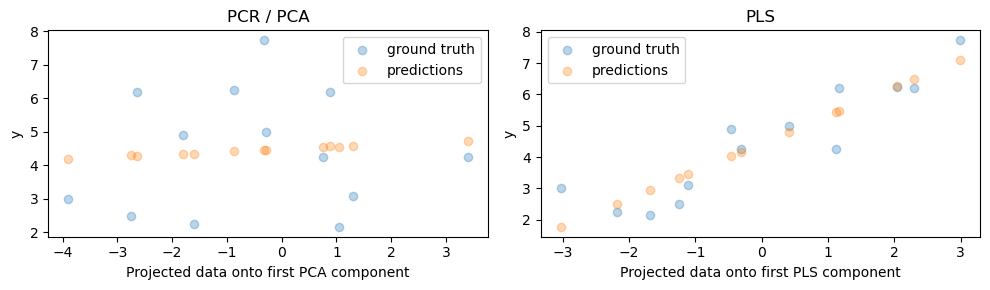

PCR r-squared 0.007
PLS r-squared 0.837


In [20]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#rng = np.random.RandomState(0)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=rng)
X_train, X_test, y_train, y_test = X, X, Y, Y

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

In [21]:
pca_2 = make_pipeline(PCA(n_components=2), LinearRegression())
pca_2.fit(X_train, y_train)
print(f"PCR r-squared with 2 components {pca_2.score(X_test, y_test):.3f}")

PCR r-squared with 2 components 0.009


In [22]:
# pls.coef_

In [23]:
# for iMic
df = pd.read_csv(path + 'outputs/Qiime2_stool_adh/level-6.csv', index_col=0)

# filter out metadata
for x in list(df.columns.values):
    if 'k__' not in x:
        df = df.drop(x,axis=1)

# normalize to 0-1
df = df.div(df.sum(axis=1),axis=0).T

df.to_csv(path + 'outputs/Qiime2_stool_adh/otu_table_L6.csv',index_label=None)
df.head()

index,OAD-001.post.stool,OAD-001.pre.stool,OAD-003.post.stool,OAD-003.pre.stool,OAD-004.post.stool,OAD-004.pre.stool,OAD-005.post.stool,OAD-005.pre.stool,OAD-006.post.stool,OAD-006.pre.stool,...,VAOAD-001.post.stool,VAOAD-001.pre.stool,VAOAD-004.post.stool,VAOAD-004.pre.stool,VAOAD-008.pre.stool,VAOAD-010.pre.stool,VAOAD-011.post.stool,VAOAD-011.pre.stool,VAOAD-012.post.stool,VAOAD-012.pre.stool
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter,0.006187,0.012105,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000117,0.000000,0.0,0.002044,0.000330,0.000407,0.000816,0.000000,0.0
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera,0.001754,0.000783,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__[Methanomassiliicoccaceae];g__Methanomassiliicoccus,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000557,0.000000,0.000000,0.000000,0.000000,0.0
k__Bacteria;__;__;__;__;__,0.000048,0.000119,0.0,0.000000,0.0,0.0,0.000024,0.000075,0.000967,0.000788,...,0.000037,0.000000,0.000102,0.0,0.000124,0.000000,0.000144,0.000260,0.000098,0.0
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,0.000000,0.000000,0.0,0.000272,0.0,0.0,0.001827,0.001240,0.000000,0.000000,...,0.000403,0.000753,0.000119,0.0,0.000000,0.000129,0.000000,0.000058,0.000509,0.0
